# UNet with plain discriminator loss

In [17]:
import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn    
from torch.nn import Module, Sequential
from torch.nn import Conv2d, ConvTranspose2d, BatchNorm2d, MaxPool2d, ReLU, LeakyReLU, Tanh, Sigmoid
from torch.nn import BCELoss, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchsummary import summary


from utils.image import image_from_tensor
from utils.notebook import imshow, display_tensor, display_batch
from utils.weights import weights_init_normal
from utils.masking import mask_batch

## Set seed and device

In [3]:
manual_seed = 42
# manual_seed = random.randint(1, 10000)
print("Random Seed: ", manual_seed)
random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.use_deterministic_algorithms(True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Random Seed:  42
Using device: cuda


## Config

In [ ]:
dataroot = '../.images/'
workers = 2
batch_size = 4
image_size = 256

num_channels = 3

nz = 100 
"""latent vector len"""
ngf = 64
"""generator feature map depth (channels)"""
ndf = 64 
"""discriminator feature map depth (channels)"""

num_epochs = 100
learning_rate = 0.0002
beta1 = 0.5

## Load images into dataset

In [5]:
dataset = ImageFolder(root=dataroot, transform=transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

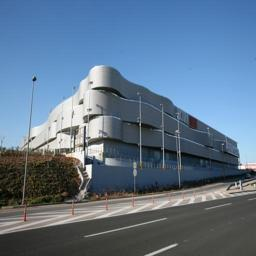

In [6]:
display_tensor(dataset[0][0])

In [7]:
dl_iter = iter(dataloader)

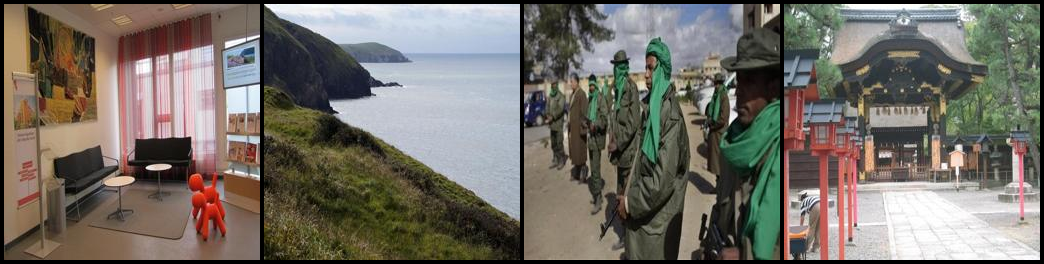

In [8]:
real_batch = next(dl_iter)
display_batch(real_batch)

## Create UNet generator and discriminator

In [9]:
class ConvBlock(Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.main = Sequential(
            Conv2d(in_channels, out_channels, kernel_size=3, padding="same", bias=False),
            BatchNorm2d(out_channels),
            ReLU(inplace=True),

            Conv2d(out_channels, out_channels, kernel_size=3, padding="same", bias=False),
            BatchNorm2d(out_channels),
            ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.main(x)
    
class DownBlock(Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        
        self.main = Sequential(
            MaxPool2d(kernel_size=2),
            ConvBlock(in_channels, out_channels)
        )
    
    def forward(self, x):
        return self.main(x)

class UpBlock(Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        
        self.up = ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)
    
    def forward(self, x, skip_connection):
        x = self.up(x)
        x = torch.cat((x, skip_connection), dim=1)
        x = self.conv(x)
        return x

In [10]:
class UNet(Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.inconv = ConvBlock(3, 64)
        self.down1 = DownBlock(64, 128)
        self.down2 = DownBlock(128, 256)
        self.down3 = DownBlock(256, 512)
        self.down4 = DownBlock(512, 1024)
        self.up1 = UpBlock(1024, 512)
        self.up2 = UpBlock(512, 256)
        self.up3 = UpBlock(256, 128)
        self.up4 = UpBlock(128, 64)
        self.outconv = Conv2d(64, 3, kernel_size=1)
        self.sigmoid = Sigmoid()

    def forward(self, x):
        x1 = self.inconv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outconv(x)
        x = self.sigmoid(x)
        return x
    
    def summary(self):
        return summary(self.to(device), (3, 256, 256))

In [11]:
UNet().summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         ConvBlock-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            UNet()
        )
    
    def forward(self, input):
        return self.main(input)

In [13]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim=64):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # input size 3 x 256 x 256
            nn.Conv2d(3, hidden_dim, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size hidden_dim x 128 x 128
            nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size (hidden_dim*2) x 64 x 64
            nn.Conv2d(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size (hidden_dim*4) x 32 x 32
            nn.Conv2d(hidden_dim * 4, hidden_dim * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size (hidden_dim*8) x 16 x 16
            nn.Conv2d(hidden_dim * 8, hidden_dim * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size (hidden_dim*8) x 8 x 8
            nn.Conv2d(hidden_dim * 8, hidden_dim * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size (hidden_dim*8) x 4 x 4
            nn.Conv2d(hidden_dim * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # state size 1 x 1 x 1
        )
    
    def forward(self, input):
        return self.main(input)
    
    def summary(self):
        return summary(self.to(device), (3, 256, 256))

In [14]:
Discriminator().summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,072
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,288
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-10          [-1, 512, 16, 16]           1,024
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 512, 8, 8]       4,194,304
      BatchNorm2d-13            [-1, 512, 8, 8]           1,024
        LeakyReLU-14            [-1, 51

Create networks and initialize weights

In [15]:
netG = Generator().to(device)
_ = netG.apply(weights_init_normal)

netD = Discriminator().to(device)
_ = netD.apply(weights_init_normal)

## Training

In [19]:
criterion = nn.BCELoss()

test_batch = next(dl_iter)[0].to(device)

real_label = 1.
fake_label = 0.

optimizerD = Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [20]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting training")

for epoch in trange(num_epochs):
    for i, data in enumerate(tqdm(dataloader), 0):
        
        # Update discriminator 

        ## real batch
        netD.zero_grad()
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        output = netD(real).view(-1)

        lossD_real = criterion(output, label)
        lossD_real.backward()
        D_x = output.mean().item()

        ## fake batch
        masked = mask_batch(real)

        fake = netG(masked)

        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)

        lossD_fake = criterion(output, label)
        lossD_fake.backward()

        D_G_z1 = output.mean().item()
        
        lossD = lossD_real + lossD_fake
        optimizerD.step()


        # Update generator
        netG.zero_grad()
        label.fill_(real_label) # for generator loss labels are inverted

        output = netD(fake).view(-1)

        lossG = criterion(output, label)
        lossG.backward()

        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]  Loss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))

        
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

        # check generator progress
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(test_batch).detach().cpu()
            img_list.append(make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting training


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/803 [00:00<?, ?it/s]

[0/100][0/803]	Loss_D: 1.4936	Loss_G: 25.5776	D(x): 0.7273	D(G(z)): 0.6468 / 0.0000
[0/100][50/803]	Loss_D: 0.0028	Loss_G: 8.3610	D(x): 0.9983	D(G(z)): 0.0011 / 0.0005
[0/100][100/803]	Loss_D: 0.0000	Loss_G: 16.0313	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/100][150/803]	Loss_D: 0.0000	Loss_G: 24.7837	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/100][200/803]	Loss_D: 0.0000	Loss_G: 39.4525	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/100][250/803]	Loss_D: 0.0000	Loss_G: 29.4053	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


KeyboardInterrupt: 

Save trained models

In [ ]:
torch.save(netG.state_dict(), 'big_generator4.pth')
torch.save(netD.state_dict(), 'big_discriminator4.pth')

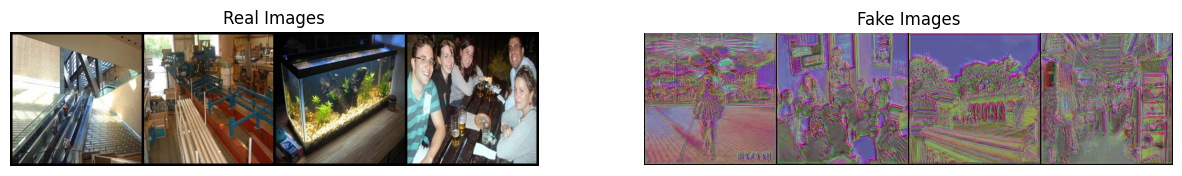

In [ ]:
# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [27]:
test = next(dl_iter)[0]
test_mask = mask_batch(test).to(device)

In [ ]:
from utils.image import image_from_tensor
from utils.notebook import imshow
from utils.tensor import tensor_to_numpy

In [115]:
test[0].shape

torch.Size([3, 256, 256])

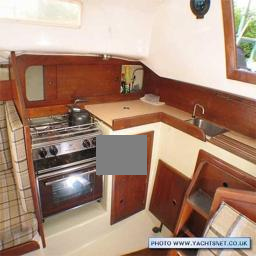

In [28]:
imshow(image_from_tensor(test_mask[0]))

In [157]:
test_mask.dtype

torch.float32

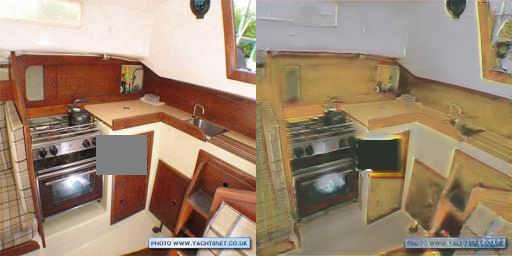

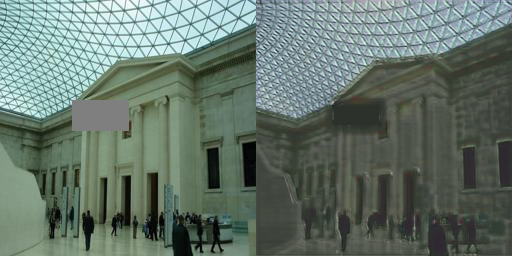

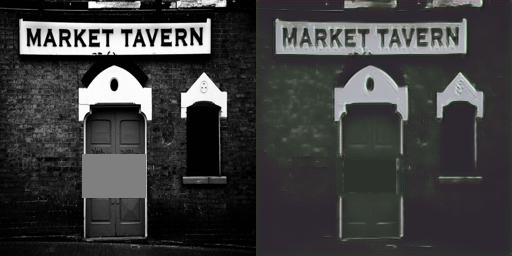

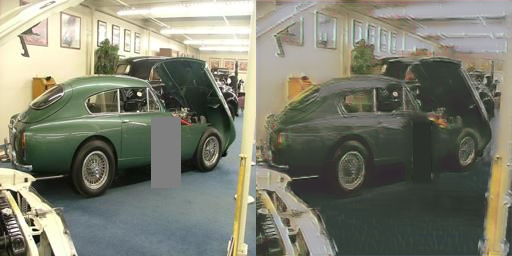

In [29]:
with torch.no_grad():
    res = netG2(test_mask)
    for i in range(batch_size):
       imshow(np.concatenate([image_from_tensor(test_mask[i]), image_from_tensor(res[i])], axis=1))


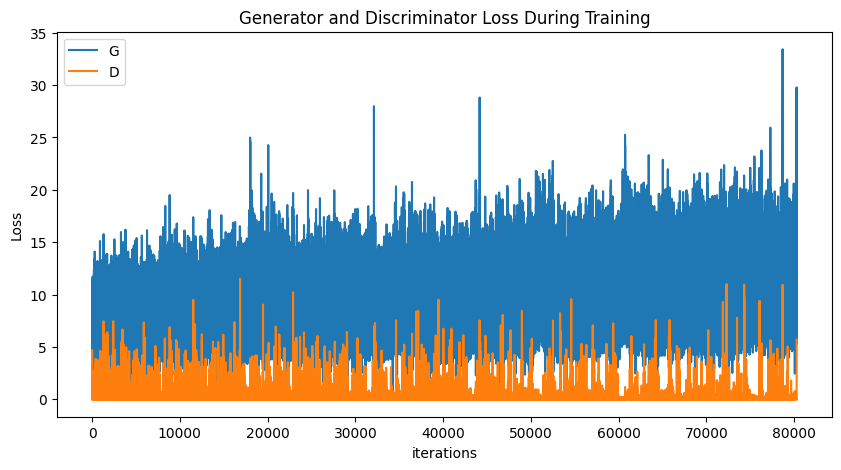

In [30]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()